# Working on Completness & Purity before creating a function for it (P-matching)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import GCRCatalogs
from GCRCatalogs.helpers.tract_catalogs import tract_filter, sample_filter
from GCRCatalogs import GCRQuery
from astropy.table import Table
from astropy.io import fits
import pandas as pd
%load_ext autoreload
%autoreload 0
###clevar
import clevar
from clevar import ClCatalog

ModuleNotFoundError: No module named 'clevar'

In [2]:
outpath = '/pbs/home/n/namourou/test_jupyter/cluster_challenge/notebooks/outfiles_1013/'
plotspath = '/pbs/home/n/namourou/test_jupyter/cluster_challenge/notebooks/plots/amico_plots/'
cdc = ClCatalog.read_full(outpath + 'cdc.fits') #cosmoDC2_small matched table
cam = ClCatalog.read_full(outpath + 'cam.fits') #amico matched table
mt1, mt2 = get_matched_pairs(cdc, cam, 'cross')
c_merged = ClCatalog.read(outpath +'output_catalog.fits', 'merged',  tags = {'z_halo' : 'cat1_z', 'z_amico' : 'cat2_z', 'richness' : 'cat2_richness', 'mass' : 'cat1_mass', 'SN' : 'cat2_SN'})

    * ClEvar used in matching: 0.13.8
    * ClEvar used in matching: 0.13.8


/sps/lsst/users/namourou/conda_clone_210223/descv1.1/clevar/clevar/catalog.py:267: UserWarning: id column missing, additional one is being created.
  warnings.warn(


## Clevar's completness

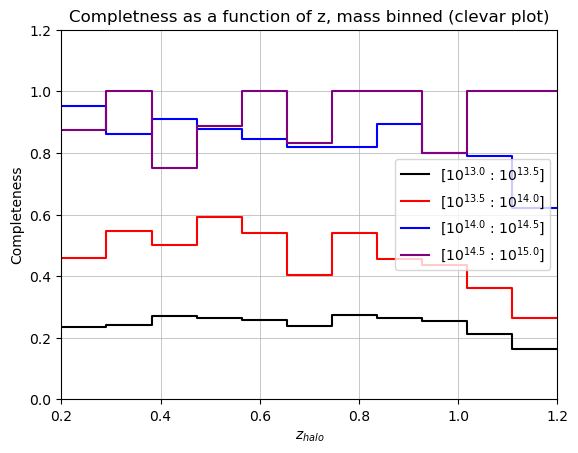

In [64]:
from clevar.match_metrics.recovery import ClCatalogFuncs as r_cf
#zbins = np.linspace(0.2,1.5,14)
zbins = np.linspace(0.2,1.2,12)
mbins = [10**13,10**13.5,10**14,10**14.5,10**15]
#zbins = np.linspace(0, 1.6, 9)
#mbins = np.logspace(14, 15, 5)
fig = plt.figure()#figsize=(figx,figy))
info = r_cf.plot(cdc, col1='z', col2='mass', bins1=zbins, bins2=mbins, matching_type='cross', legend_format=lambda x: f'10^{{{np.log10(x)}}}', lines_kwargs_list = [{'color':'black'}, {'color':'red'}, {'color':'blue'}, {'color':'purple'}])
info['ax'].set_xlabel('$z_{halo}$')
info['ax'].set_ylabel('Completeness') 
info['ax'].set_title('Completness as a function of z, mass binned (clevar plot)') 
info['ax'].set_ylim(0,1.2)
info['ax'].set_xlim(0.2,1.2) 
#info['ax'].set_title(matching)
plt.savefig(plotspath+'completness_vs_z_mbinned_clevar.png', bbox_inches='tight')
#plt.close(fig)


## Completness "a la main"

### Versus redshift

In [61]:
###completeness
#versus z
bin_range = [0.2,1.2]
nbins_x = 9
x_bins = np.linspace(0.2,1.2,nbins_x+1)
mbins = [10**13,10**13.5,10**14,10**14.5,10**15]
compl_z_raw = np.empty([4,nbins_x])

for i in range(0,4):
    print('-----'+str(i))
    cut1 = mbins[i]
    cut2 = mbins[i+1]
    filter1 = np.logical_and(c_merged.data['cat1_mass'] > cut1, c_merged.data['cat1_mass'] < cut2)
    c_halos_matched = c_merged[filter1]
    #print(c_halos_matched)
    filter2 = np.logical_and(cdc.data['mass'] > cut1, cdc.data['mass'] < cut2)
    c_halos = cdc.data[filter2]
    #print(c_halos)
    h_r_halos_matched = np.histogram(c_halos_matched['z_halo'], bins=nbins_x, range=bin_range, normed=None, weights=None, density=None)
    h_r_halos  = np.histogram(c_halos['z'], bins=nbins_x, range=bin_range, normed=None, weights=None, density=None)
    #print(h_r_halos_matched)
    #print(h_r_halos)
    compl_z_raw[i] = np.divide(h_r_halos_matched[0],h_r_halos[0],where=(h_r_halos[0]!=0))
    #print(compl_z_raw[i])
    #plt.hist(compl_z_raw[i])
    

-----0
-----1
-----2
-----3


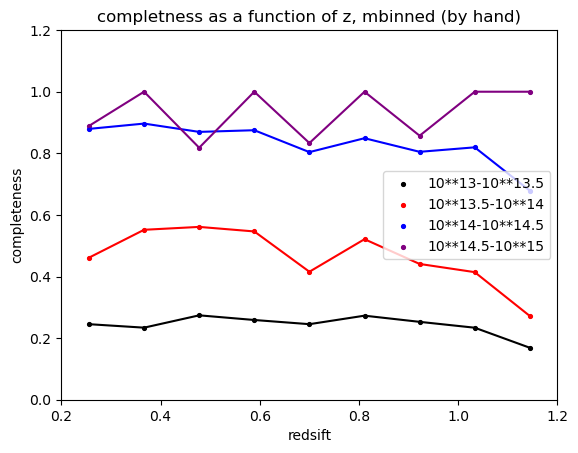

In [62]:
nbins_x = 9
x_bins = np.linspace(0.2,1.2,nbins_x+1)
bin_x = np.empty([nbins_x])
labels=['10**13-10**13.5','10**13.5-10**14','10**14-10**14.5','10**14.5-10**15']
colors=['black','red','blue','purple']
#labels=['0.2-0.4','0.4-0.6','0.6-0.8','0.8-1.0','1.0-1.2']
#colors=['black','red','blue','purple','brown']
for ix in range(nbins_x):
     bin_x[ix] = 0.5 * (x_bins[ix] + x_bins[ix+1])
plt.figure()
for i in range(0,4): 
    plt.scatter(bin_x, compl_z_raw[i], label=labels[i], color=colors[i], marker= ".", s=30)
    plt.plot(bin_x, compl_z_raw[i], color=colors[i])
    #plt.plot(x, f_completeness_param_2_fit, color=colors[i], linewidth=2.0,label="Param")
plt.legend()
plt.xlabel('redsift')
plt.ylabel('completeness')
plt.ylim(0,1.2)
plt.xlim(0.2,1.2) 
plt.title('completness as a function of z, mbinned (by hand)')
plt.savefig(plotspath+'completness_vs_z_mbinned.png', bbox_inches='tight')

### Versus mass

In [63]:
#versus mass
print('++++++++++++++++Completeness in mass bins')
bin_range = [10**13,10**15]
nbins_x = 9
zbins = [0.2,0.5,0.8,1.0,1.2]
#zbins = [0.2,0.4,0.6,0.8,1.0,1.2]
nbins_z=len(zbins)-1
compl_m_raw = np.empty([nbins_z,nbins_x])
z_l = []
for i in range(0,nbins_z):
    print('-----'+str(i))
    cut1 = zbins[i]
    cut2 = zbins[i+1]
    filter1 = np.logical_and(c_merged.data['cat1_z'] > cut1, c_merged.data['cat1_z'] < cut2)
    c_halos_matched = c_merged[filter1]
    #print(c_halos_matched)
    filter2 = np.logical_and(cdc.data['z'] > cut1, cdc.data['z'] < cut2)
    c_halos = cdc.data[filter2]
    #print(c_halos)
    h_r_halos_matched = np.histogram(c_halos_matched['cat1_mass'], bins=nbins_x, range=bin_range, normed=None, weights=None, density=None)
    h_r_halos  = np.histogram(c_halos['mass'], bins=nbins_x, range=bin_range, normed=None, weights=None, density=None)
    #print(h_r_halos)
    #print(h_r_halos_matched)
    compl_m_raw[i] = np.divide(h_r_halos_matched[0],h_r_halos[0],where=(h_r_halos[0]!=0))
    #print(compl_m_raw[i])
    #plt.hist(compl_m_raw[i]


++++++++++++++++Completeness in mass bins
-----0
-----1
-----2
-----3


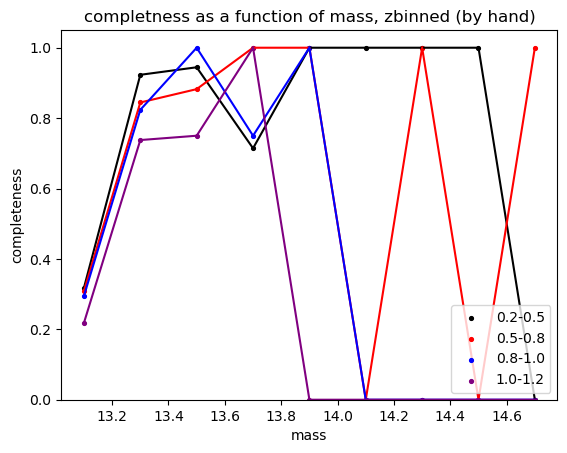

In [60]:
bin_x = np.empty([nbins_x])
x_bins = np.linspace(13,14.8,nbins_x+1)
labels=['0.2-0.5','0.5-0.8','0.8-1.0','1.0-1.2']
colors=['black','red','blue','purple']
#labels=['0.2-0.4','0.4-0.6','0.6-0.8','0.8-1.0','1.0-1.2']
#colors=['black','red','blue','purple','brown']
for ix in range(nbins_x):
     bin_x[ix] = 0.5 * (x_bins[ix] + x_bins[ix+1])
plt.figure()
x = np.linspace(13, 14.8, 2000)
for i in range(0,nbins_z): 
    plt.scatter(bin_x, compl_m_raw[i], label=labels[i], color=colors[i], marker= ".", s=30)
    plt.plot(bin_x, compl_m_raw[i], color=colors[i])
    #plt.plot(x, f_completeness_param_2_fit, color=colors[i], linewidth=2.0,label="Param")
plt.legend()
plt.xlabel('mass')
plt.ylabel('completeness')
plt.ylim(0,1.05)
#plt.xlim(0.2,1.2) 
plt.title('completness as a function of mass, zbinned (by hand)')
plt.savefig(plotspath+'completness_vs_m_zbinned.png', bbox_inches='tight')

### 2D Plot

In [30]:
#2D : z-M plane
nbins_x = 16
nbins_y = 20
x_bins = np.linspace(0.2,1.2,16)
#y_bins = np.logspace(10**13,10**15,10)
y_bins = (np.logspace(13,15,20))
#print(x_bins)
#print(y_bins)
h2_z_halos_matched = np.histogram2d(c_merged['cat1_z'], c_merged['cat1_mass'], bins=(x_bins,y_bins), range=[[x_bins[0],x_bins[nbins_x-1]],[10**13,10**15]], normed=None, weights=None, density=None)
h2_z_halos = np.histogram2d(cdc.data['z'], cdc.data['mass'], bins=(x_bins,y_bins), range=[[0,1.2],[10**13,10**15]], normed=None, weights=None, density=None)

n_halo_min = 10
number_of_match = h2_z_halos_matched[0]
number_of_halo = h2_z_halos[0]
compl_2d_raw = (number_of_match/number_of_halo)
compl_2d = np.ma.masked_where(number_of_halo<n_halo_min, compl_2d_raw)
#print(compl_2d)
#print("2D")

#NOT USED FOR NOW: bin-by-bin computation of the completeness
completeness_z_halo_mass = [[0]*(nbins_y)]*(nbins_x)
for ix in range(nbins_x-1):
    #print(ix)
    for iy in range(nbins_y-1):
        #print("loop iy")
        #print(iy)
        #print((h2_z_halos_matched[0][ix])[iy])
        #print((h2_z_halos[0][ix])[iy])
        inclusive = (h2_z_halos[0][ix])[iy]
        matched = (h2_z_halos_matched[0][ix])[iy]
        completeness_z_halo_mass[ix][iy]=0
        if(inclusive!=0):
            completeness_z_halo_mass[ix][iy] = matched/inclusive
            #print("completeness = " + str(completeness_z_halo_mass[ix][iy]))
#NOT USED FOR NOW

/tmp/ipykernel_133/411974687.py:15: RuntimeWarning: invalid value encountered in divide
  compl_2d_raw = (number_of_match/number_of_halo)


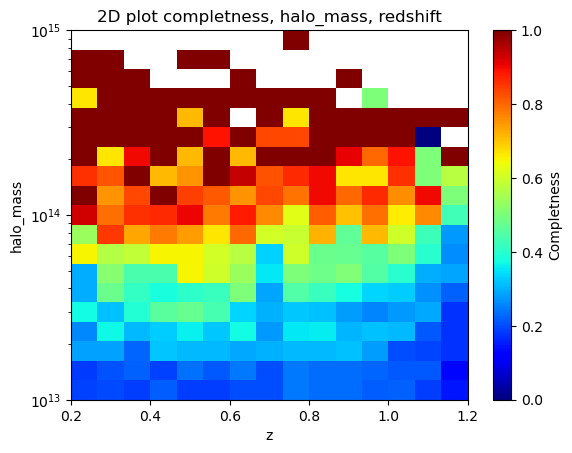

In [32]:
#2D plot
fig, ax = plt.subplots()
x, y = np.meshgrid(x_bins, y_bins)
#print(x)
#print(y)
c = ax.pcolormesh(x, y, compl_2d_raw.T, cmap='jet', vmin=0, vmax=1)
ax.set_xlim(0.2,1.2)
ax.set_ylim(10**13,10**15)
ax.set_xlabel('z')
ax.set_ylabel('halo_mass')
ax.set_yscale('log')
ax.set_title('2D plot completness, halo_mass, redshift')
fig.colorbar(c, ax=ax, label = 'Completness')
plt.savefig(plotspath+'2D_comp_plot.png', bbox_inches='tight')

## Purity

In [66]:
###### Purity
print('++++++++++++++++Purity in redshif bins')
bin_range = [1.5,4.5]
mbin_range = [13,40]
nbins_x = 6
zbins = [0.2,0.5,0.8,1.0,1.15]
purity_m_raw = np.empty([4,nbins_x])

for i in range(0,4):
    print('-----'+str(i))
    cut1 = zbins[i]
    cut2 = zbins[i+1]
    filter1 = np.logical_and(c_merged.data['cat2_z'] > cut1, c_merged.data['cat2_z'] < cut2)
    c_clusters_matched = c_merged[filter1]
    #print(c_halos_matched)
    filter2 = np.logical_and(cam.data['z'] > cut1, cam.data['z'] < cut2)
    c_clusters = cam.data[filter2]
    #print(c_halos)
    h_r_clusters_matched = np.histogram(np.log(c_clusters_matched['richness']), bins=nbins_x, range=bin_range, normed=None, weights=None, density=None)
    h_r_clusters  = np.histogram(np.log(c_clusters['richness']), bins=nbins_x, range=bin_range, normed=None, weights=None, density=None)
    print(h_r_clusters_matched)
    print(h_r_clusters)
    purity_m_raw[i] = np.divide(h_r_clusters_matched[0],h_r_clusters[0],where=(h_r_clusters[0]!=0))
    print(purity_m_raw[i])

++++++++++++++++Purity in richness bins
-----0
(array([416, 836, 384, 113,  39,   4]), array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]))
(array([559, 915, 388, 115,  39,   4]), array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]))
[0.74418605 0.9136612  0.98969072 0.9826087  1.         1.        ]
-----1
(array([ 442, 1536,  733,  171,   35,   10]), array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]))
(array([ 601, 1851,  777,  173,   36,   10]), array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]))
[0.73544093 0.82982172 0.94337194 0.98843931 0.97222222 1.        ]
-----2
(array([  31,  952, 1360,  345,   46,    8]), array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]))
(array([  46, 1190, 1542,  356,   47,    8]), array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]))
[0.67391304 0.8        0.88197147 0.96910112 0.9787234  1.        ]
-----3
(array([  3, 188, 811, 278,  24,   1]), array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]))
(array([  6, 252, 945, 296,  24,   1]), array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]))
[0.5        0.74603175 0.8582010

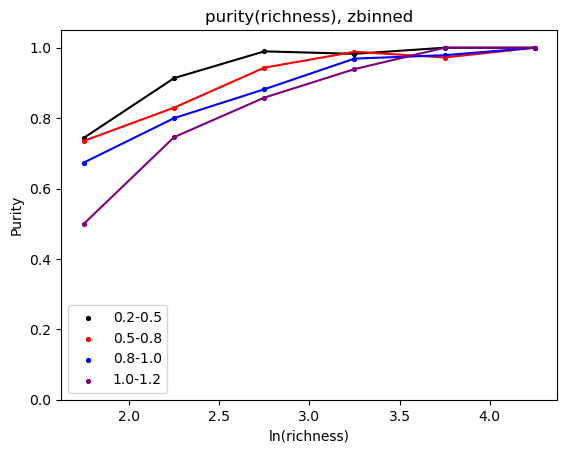

In [67]:
#plot in bins of redshift
bin_x = np.empty([nbins_x])
x_bins = np.linspace(1.5,4.5,nbins_x+1)
labels=['0.2-0.5','0.5-0.8','0.8-1.0','1.0-1.2']
colors=['black','red','blue','purple']
for ix in range(nbins_x):
     bin_x[ix] = 0.5 * (x_bins[ix] + x_bins[ix+1])
plt.figure()
for i in range(0,4): 
    plt.scatter(bin_x, purity_m_raw[i], label=labels[i], color=colors[i], marker= ".", s=30)
    plt.plot(bin_x, purity_m_raw[i], color=colors[i])
plt.xlabel('ln(richness)')
plt.ylabel('Purity')
plt.legend()
plt.ylim(0,1.05)
#plt.xlim(0.2,1.2) 
plt.title('purity(richness), zbinned')
plt.savefig(plotspath+'purity_vs_lmbd_zbinned.png', bbox_inches='tight')